In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Load

In [35]:
data = pd.read_excel('discount_curve_swaps.xlsx', sheet_name='swap discount curve')

In [36]:
data.head()

,maturity,last update,swap rate,spot disc rate
0,2025-10-01,2025-07-28,0.043342,0.044119
1,2026-01-01,2025-07-28,0.042236,0.042740
2,2026-04-01,2025-07-28,0.041237,0.041503
3,2026-07-01,2025-07-28,0.040290,0.040339
4,2026-10-01,2025-07-28,0.039257,0.039340


# Fitting the SOFR-Swap Discount Curves

#### 1.1
The discount rates are provided in annual compounding. Convert them to continuously compounded rates, and plot both.

The equivalence between annual and continuous compounding for time period $T$:

$$(1 + r_{\text{annual}})^T = e^{r_{\text{continuous}} \cdot T}$$

Therefore:

$$r_{\text{continuous}} = \ln(1 + r_{\text{annual}})$$

In [37]:
data['maturity'] = pd.to_datetime(data['maturity'])
val_date = pd.to_datetime(data['last update'].iloc[0])
data['T'] = (data['maturity'] - val_date).dt.days / 365
data['r_annual'] = data['spot disc rate']
data['r_continuous'] = np.log(1 + data['r_annual'])

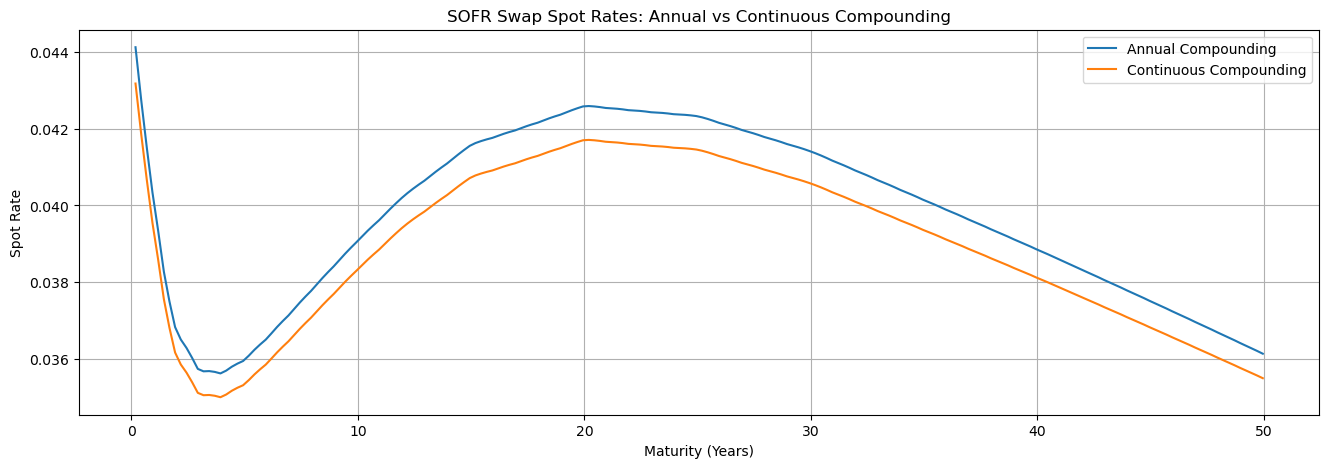

In [38]:
plt.figure(figsize=(16,5))

plt.plot(
    data['T'],
    data['r_annual'],
    label='Annual Compounding',
)

plt.plot(
    data['T'],
    data['r_continuous'],
    label='Continuous Compounding',
)

plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate')
plt.title('SOFR Swap Spot Rates: Annual vs Continuous Compounding')
plt.legend()
plt.grid(True)

plt.show()


#### 1.2

Use (either compounding) to calculate the discount factors. Plot them.

The discount factor $DF(T)$ is the present value of \$1 received at time $T$:

$$DF(T) = \frac{1}{(1 + r_{\text{annual}})^T}$$

Equivalently using continuous compounding: $DF(T) = e^{-r_{\text{continuous}} \cdot T}$

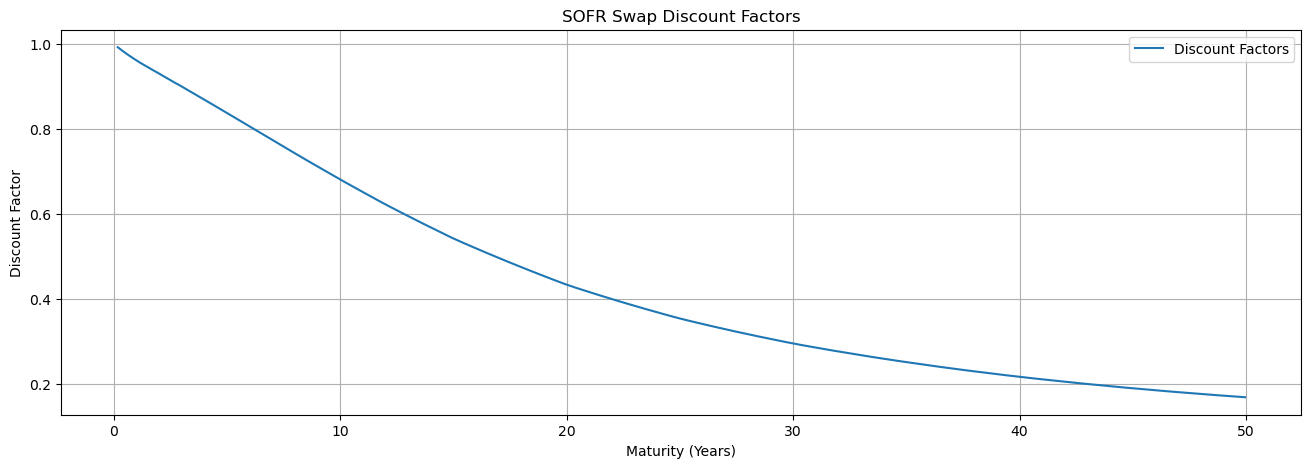

In [39]:
data['DF_annual'] = 1 / (1 + data['r_annual'])**data['T']
plt.figure(figsize=(16,5))

plt.plot(
    data['T'],
    data['DF_annual'],
    label='Discount Factors',
)

plt.xlabel('Maturity (Years)')
plt.ylabel('Discount Factor')
plt.title('SOFR Swap Discount Factors')
plt.grid(True)
plt.legend()

plt.show()


#### 1.3 

Calculate the forward curve, setting the forward increment to be the same as the increment in the spacing of the maturities. That is, for rates quoted every three months, build the forward curve for a forward term of three months.

Plot the forward curve rates against the spot curve rates.

The forward rate $f(t_1, t_2)$ satisfies the no-arbitrage relationship:

$$DF(t_1) = DF(t_2) \cdot (1 + f(t_1, t_2) \cdot \Delta T)$$

where $\Delta T = t_2 - t_1$. Solving for the simply-compounded forward rate:

$$f(t_1, t_2) = \frac{1}{\Delta T} \left(\frac{DF(t_1)}{DF(t_2)} - 1\right)$$

In [40]:
# sort by maturity
data = data.sort_values('T').reset_index(drop=True)

# time increments (~0.25 years)
data['delta_T'] = data['T'].diff()

# 3M forward rates (annualized, simple compounding)
data['forward_rate_ann'] = (
    data['DF_annual'].shift(1) / data['DF_annual'] - 1
) / data['delta_T']


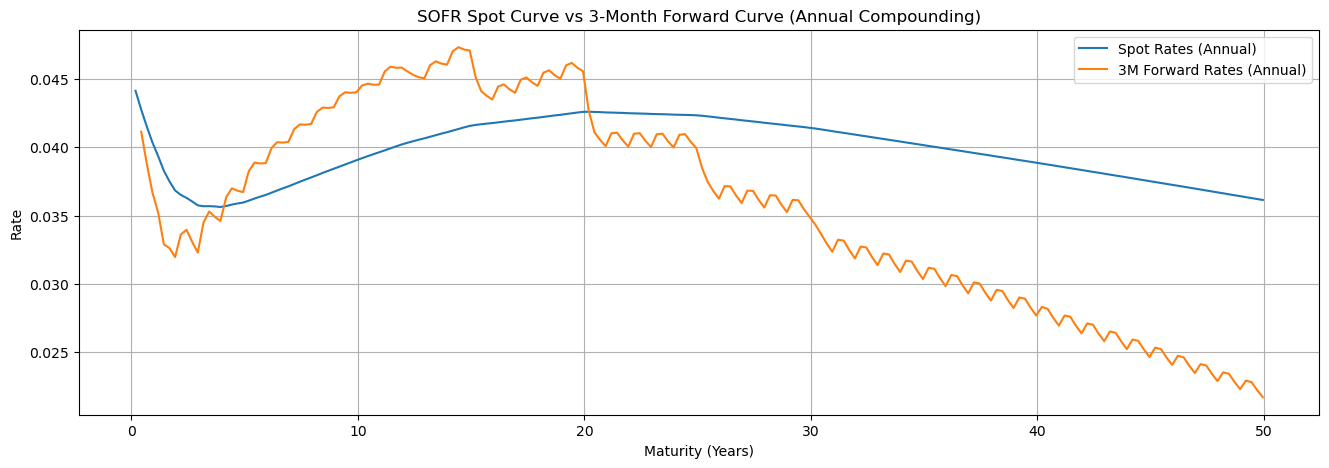

In [41]:
plt.figure(figsize=(16,5))

plt.plot(
    data['T'],
    data['r_annual'],
    label='Spot Rates (Annual)',
)

plt.plot(
    data['T'],
    data['forward_rate_ann'],
    label='3M Forward Rates (Annual)',
)

plt.xlabel('Maturity (Years)')
plt.ylabel('Rate')
plt.title('SOFR Spot Curve vs 3-Month Forward Curve (Annual Compounding)')
plt.legend()
plt.grid(True)

plt.show()


#### 1.4 
Calculate the forward Factor term t = 2 -> 2.25

The forward factor represents the growth of \$1 from time $t_1$ to $t_2$:

$$FF(t_1, t_2) = \frac{DF(t_1)}{DF(t_2)}$$

This equals $1 + f(t_1, t_2) \cdot \Delta T$, the accrual factor for the forward period.

In [42]:
DF_2_00 = data.loc[(data['T'] - 2.00).abs().idxmin(), 'DF_annual']
DF_2_25 = data.loc[(data['T'] - 2.25).abs().idxmin(), 'DF_annual']

forward_factor = DF_2_00 / DF_2_25
forward_factor


np.float64(1.0084725266580787)

# 2. Estimating the Spot Rate

Recovering the spot rate from the discount factor using the inverse relationship:

$$DF(T) = \frac{1}{(1 + r)^T}$$

Solving for $r$:

$$r = DF(T)^{-1/T} - 1$$

This verifies the original spot discount rates by inverting the discount factor formula.

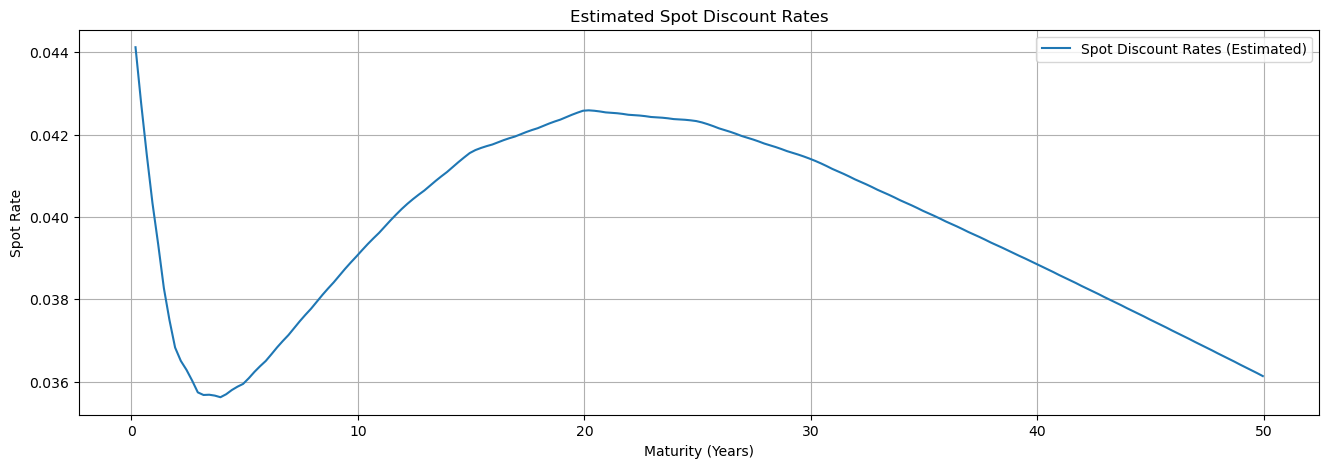

In [48]:
data['spot_rate_est'] = data['DF_annual']**(-1 / data['T']) - 1

plt.figure(figsize=(16,5))
plt.plot(
    data['T'],
    data['spot_rate_est'],
    label='Spot Discount Rates (Estimated)'
)
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate')
plt.title('Estimated Spot Discount Rates')
plt.grid(True)
plt.legend()
plt.show()


The plot below illustrates the spot discount factors across maturities. The discount factors decrease monotonically from one at short maturities, reflecting positive interest rates and a well-behaved term structure.

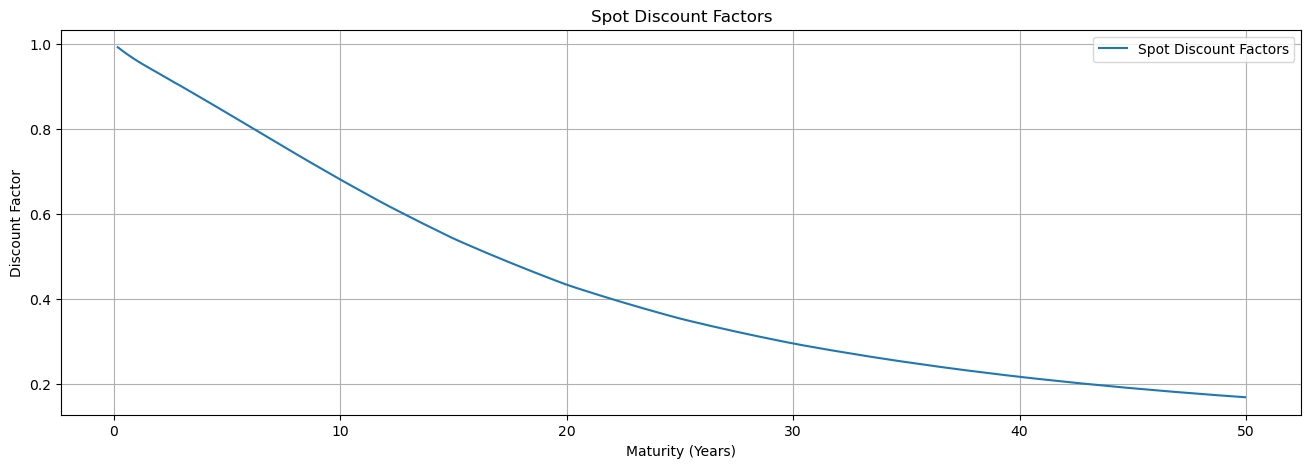

In [49]:
plt.figure(figsize=(16,5))
plt.plot(
    data['T'],
    data['DF_annual'],
    label='Spot Discount Factors'
)
plt.xlabel('Maturity (Years)')
plt.ylabel('Discount Factor')
plt.title('Spot Discount Factors')
plt.grid(True)
plt.legend()
plt.show()


# 3. Interpolating Swap Rates
Use the data in swap rates benchmark, and interpolate a curve such that you have swap rates at evenly spaced increments of increment=0.25 through maturity T=30.

Plot the interpolated curve against the raw data.

In [59]:
def tenor_to_years(tenor):
    tenor = str(tenor).strip().upper()
    if tenor.endswith('W'):
        return int(tenor[:-1]) / 52
    elif tenor.endswith('M'):
        return int(tenor[:-1]) / 12
    elif tenor.endswith('Y'):
        return int(tenor[:-1])
    else:
        raise ValueError(f"Unknown tenor format: {tenor}")

benchmark = pd.read_excel('discount_curve_swaps.xlsx', sheet_name='swap rates benchmark')
benchmark['T'] = benchmark['tenor'].apply(tenor_to_years)

# keep only the region you need for interpolation
benchmark = benchmark[(benchmark['T'] >= 0.25) & (benchmark['T'] <= 30)].sort_values('T')


In [60]:
T_grid = np.arange(0.25, 30.25, 0.25)

interp_rates = np.interp(T_grid, benchmark['T'], benchmark['rate'])

interp_curve = pd.DataFrame({'T': T_grid, 'rate_interp': interp_rates})


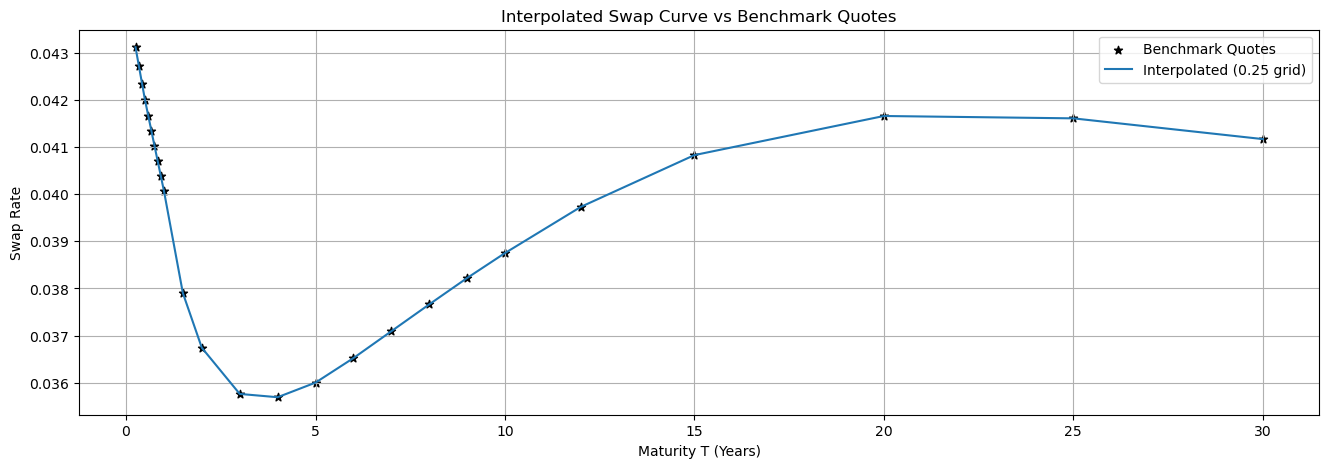

In [64]:
plt.figure(figsize=(16,5))
plt.scatter(benchmark['T'], benchmark['rate'], label='Benchmark Quotes', color='black', marker ='*')
plt.plot(interp_curve['T'], interp_curve['rate_interp'], label='Interpolated (0.25 grid)')
plt.xlabel('Maturity T (Years)')
plt.ylabel('Swap Rate')
plt.title('Interpolated Swap Curve vs Benchmark Quotes')
plt.grid(True)
plt.legend()
plt.show()